In [1]:
import numpy as np
import pandas as pd
import dask.dataframe as dd

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns

from tqdm.notebook import tqdm

In [3]:
%%time

datasets = {
    'AmpC':'../data/AmpC_screen_table_1M/result_single_Morgan_size=2048_radius=2.csv',
    'AmpC_norm' : '/storage/margaritakovaleva/2021-06-15_big_datasets/AmpC_screen_table_1M/result_single_uniformed_scores_Morgan_size=2048_radius=2.csv'}
dataset_size = {'AmpC':96214206, 'AmpC_norm':96214206}

dfs = []
for name, path in tqdm(datasets.items()):
    df = pd.read_csv(path)
    df['proj'] = name
    df['N_ligands'] = dataset_size.get(name)
    dfs.append(df)

raw_data = pd.concat(dfs)

  0%|          | 0/2 [00:00<?, ?it/s]

CPU times: user 24.7 ms, sys: 5.31 ms, total: 30 ms
Wall time: 26.6 ms


In [5]:
def threshold2int(s: str) -> int:
    return float(s.replace('%',' ').split()[1])

def threshold_to_int(df: pd.DataFrame) -> pd.DataFrame:
    df['top_threshold'] = df.apply(
        {'top_threshold':threshold2int}
    )
    return df


def add_ratio(df: pd.DataFrame) -> pd.DataFrame:
    # D4 from "Ultra-large for discovering chemotypes"
    # around 1s per ligand
    sec_per_ligand = 43_563*60*60 / 138_000_000 
    
    top_percentage = df.top_threshold / 100.
    
    time_spent_for_ML = df.docked*sec_per_ligand + df.time_sec
    ligands_docked_if_we_did_docking = (time_spent_for_ML / time_in_seconds_per_ligand)
    ligands_gained_with_ML = df.docked*top_percentage + df.TP
    ligands_gained_with_docking = ligands_docked_if_we_did_docking*top_percentage
    
    df['ML_gain'] = ligands_gained_with_ML / ligands_gained_with_docking
    return df


def add_gain_with_extrapolation(df: pd.DataFrame) -> pd.DataFrame:
    # D4 from "Ultra-large for discovering chemotypes"
    # around 1s per ligand
    sec_per_ligand = 43_563*60*60 / 138_000_000 
    
    top_percentage = df.top_threshold / 100.
    
    # here we extrapolate recall to the rest of the dataset
    # among all ligands not yet docked, we predict top_percentage as hits,
    # and then recall_score of them are true ligands
    ligands_gained_only_with_ML = (df.N_ligands - df.docked)*top_percentage*df.recall_score
    ligands_gained_with_ML = ligands_gained_only_with_ML + df.docked*top_percentage    
    
    time_spent_for_ML = (0 
        + df.docked*sec_per_ligand  # docking of train set
        + df.time_sec  # train-predict loop
        + (df.N_ligands-df.docked)*top_percentage*sec_per_ligand  # docking of predicted top_threshold of ligands
                        )

    ligands_docked_if_we_did_docking = (time_spent_for_ML / sec_per_ligand)
    ligands_docked_if_we_did_docking = pd.concat([ligands_docked_if_we_did_docking, df.N_ligands], axis=1).min(axis=1)
    
    ligands_gained_with_docking = ligands_docked_if_we_did_docking*top_percentage
    
    df['ML_gain_big'] = ligands_gained_with_ML / ligands_gained_with_docking
    return df

In [12]:
df = (
    raw_data
    .drop('Unnamed: 0', axis=1)
    .dropna(axis=1)
    .pipe(threshold_to_int)
    .rename({'type':'model_type'}, axis=1)
#     .query('model_type == "regressor"')
    .query('top_threshold == 1')
#     .query('proj == "4eiy"')
    .sort_values(['model','train_size'])
#     .pipe(add_ratio)
#     .pipe(add_gain_with_extrapolation)
#     .assign(TP = lambda df: df.TP*400)
#     .assign(log2_time_sec = lambda df: np.log2(df.time_sec))
#     .groupby(['model','proj','model_type','train_size', 'top_threshold'], as_index=False).agg('median')
)

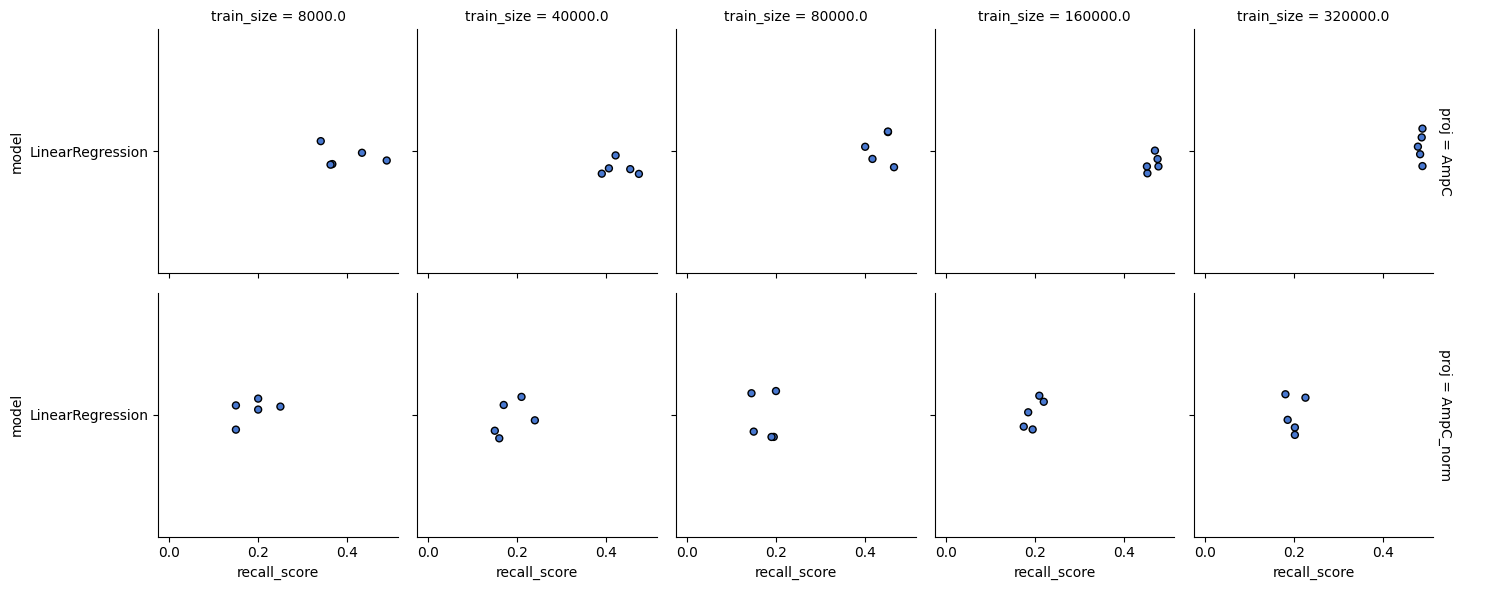

In [15]:
kwa = {
    'x': "recall_score", 
    'y': "model",
#     'orient':'h',
    'edgecolor':'k',
    'linewidth':1,
    'palette':'muted',
#     'order':sorted(df.model.unique())    
}

grid = \
sns.FacetGrid(df, 
              col = "train_size", 
              row = "proj", 
              sharey=True, 
              sharex=True,
              margin_titles=True,
             )
(
    grid
    .map_dataframe(sns.stripplot, **kwa)
)

grid.add_legend()
plt.savefig('../figures/Figure_2_norm.png', dpi=300)
plt.show()